# Word Embeddings for Text Analysis


- Predict analogies between words.
- PCA for dimensionality.
- Word similarity measure.
- Vector space models.


In [21]:
#!pip install 
#!pip install matplotlib

<a name='1'></a>
## 1 - Predict the Countries from Capitals

In [2]:
# Run this cell to import packages.
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df=pd.read_csv('country-list.csv')

In [4]:
combined_set = set(pd.concat([df['country'], df['capital']]))


In [5]:
import nltk
from gensim.models import KeyedVectors

#Download the dataset from this [page](https://code.google.com/archive/p/word2vec/) and unzip the file


embeddings = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)

select_words = words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    combined_set.add(w)


In [8]:
def get_word_embeddings(embeddings, combined_set):
    word_embeddings = {}
    for word, idx in embeddings.key_to_index.items():
        if word in combined_set:
            word_embeddings[word] = embeddings.vectors[idx]
    return word_embeddings


In [9]:

# Testing your function
word_embeddings = get_word_embeddings(embeddings, combined_set)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "word_embeddings_subset.p", "wb" ) )

378


In [11]:
word_embeddings = pickle.load(open("./word_embeddings_subset.p", "rb"))
len(word_embeddings)  # there should be 243 words that will be used in this assignment

378

Each of the word embedding is a 300-dimensional vector.

In [12]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


#### Predict relationships among words

Implement a function that takes in two word vectors and computes the cosine distance.

In [13]:
# cosine_similarity

def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''

    dot = np.dot(A, B)    
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)    
    cos = dot / (norma * normb)

    return cos



In [14]:
# feel free to try different words
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

<a name='1-3'></a>
### Euclidean Distance

Implement a function that computes the Euclidean distance between two vectors.

In [15]:
#  euclidean

def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """


    # Euclidean distance
    d = np.linalg.norm(A - B)


    return d

In [16]:
# Test your function
euclidean(king, queen)

2.4796925

<a name='1-4'></a>
### Finding the Country of each Capital

In [12]:
def get_country(city1, country1, city2, embeddings, cosine_similarity=cosine_similarity):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their emmbeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """

    # Store the city1, country 1, and city 2 in a set called group
    group = {city1, country1, city2}

    # Get embeddings of city 1
    city1_emb = embeddings[city1]

    # Get embedding of country 1
    country1_emb = embeddings[country1]

    # Get embedding of city 2
    city2_emb = embeddings[city2]

    # Get embedding of country 2 (it's a combination of the embeddings of country 1, city 1, and city 2)
    # Remember: King - Man + Woman = Queen
    vec = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by similarities that are closer to +1)
    similarity = -1

    # Initialize country to an empty string
    country = ''

    # Loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # First check that the word is not already in the 'group'
        if word not in group:

            # Get the word embedding
            word_emb = embeddings[word]

            # Calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            cur_similarity = cosine_similarity(vec, word_emb)

            # If the cosine similarity is more similar than the previously best similarity...
            if cur_similarity > similarity:

                # Update the similarity to the new, better similarity
                similarity = cur_similarity

                # Store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)


    return country


In [13]:
# Testing your function, note to make it more robust you can return the 5 most similar words.
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626822)

<a name='1-5'></a>
### Model Accuracy


In [15]:
def get_accuracy(word_embeddings, data, get_country=get_country):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas DataFrame containing all the country and capital city pairs
    '''

    # Initialize num correct to zero
    num_correct = 0

    # Loop through the rows of the dataframe
    for i, row in data.iterrows():
        # Get city1
        city1 = row['city1']

        # Get country1
        country1 = row['country1']

        # Get city2
        city2 = row['city2']

        # Get country2
        country2 = row['country2']

        # Use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)

        # If the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # Increment the number of correct by 1
            num_correct += 1

    # Get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # Calculate the accuracy by dividing the number correct by m
    accuracy = num_correct / m

    return accuracy



In [16]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


<a name='2'></a>
## 2 - Plotting the vectors using PCA
The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix  ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of  covariance matrix
4. Multiply the first K eigenvectors by  normalized data. 

<a name='ex-5'></a>
### compute_pca


In [17]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    # Mean center the data
    X_demeaned = X - np.mean(X, axis=0)

    # Calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # Calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # Reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]

    # Sort the eigenvalues by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # Sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:, idx_sorted_decreasing]

    # Select the first n eigenvectors (n is desired dimension of rescaled data array, or n_components)
    eigen_vecs_subset = eigen_vecs_sorted[:, :n_components]

    # Transform the data by multiplying the transpose of the eigenvectors with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.T, X_demeaned.T).T


    return X_reduced





In [19]:
# Testing your function
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [21]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


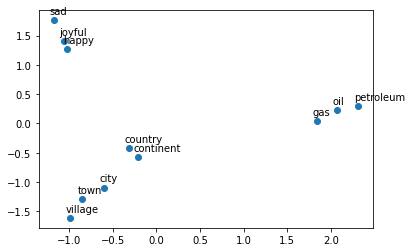

In [22]:
# We have done the plotting for you. Just run this cell.
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()